<a href="https://colab.research.google.com/github/Jundo22l/Jundo22l/blob/main/EntropyMAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


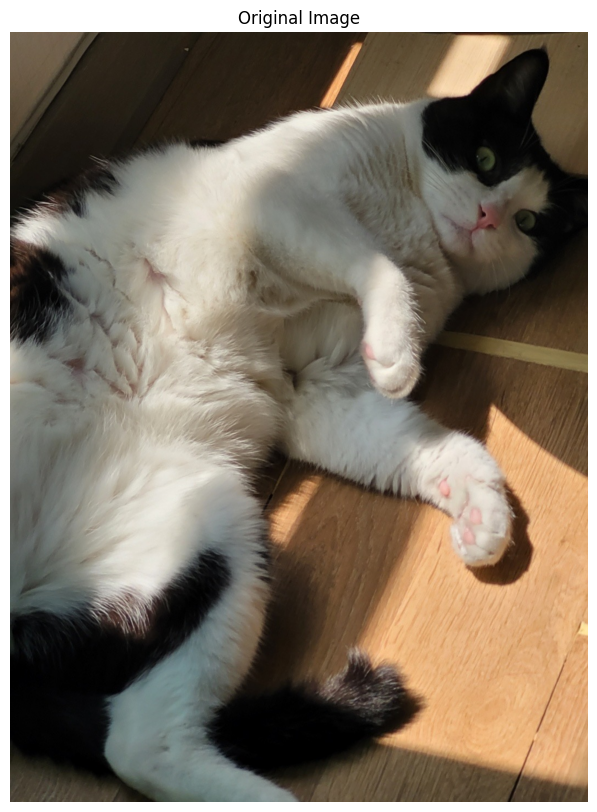

In [ ]:
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as F
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def calculate_entropy(probabilities, epsilon=1e-6):
    """
    Calculate the entropy map given the class probabilities.
    """
    entropy = -torch.sum(probabilities * torch.log(probabilities + epsilon), dim=1)
    return entropy

# 데이터 전처리 정의
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def segment_and_entropy(net, path, show_orig=True, dev='cuda'):
    img = Image.open(path).convert('RGB')
    orig_size = img.size

    if show_orig:
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Original Image')
        plt.show()

    # 이미지 전처리 및 모델 입력
    inp = transform(img).unsqueeze(0).to(dev)
    out = net(inp)['out']

    # 소프트맥스 확률 계산
    out_soft = torch.softmax(out, dim=1)

    # 엔트로피 맵 계산
    entropy_map = calculate_entropy(out_soft.squeeze(0))

    # 엔트로피 맵을 원본 이미지 크기로 리사이즈
    entropy_map_resized = F.resize(entropy_map.unsqueeze(0), size=orig_size, interpolation=F.InterpolationMode.BILINEAR).squeeze(0)

    # 엔트로피 맵 시각화
    plt.figure(figsize=(10, 10))
    plt.imshow(entropy_map_resized.cpu().detach().numpy(), cmap='jet')
    plt.colorbar()
    plt.axis('off')
    plt.title('Entropy Map')
    plt.show()

    entropy = torch.sum(entropy_map_resized).item()
    return entropy

# 모델 준비
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dlab = models.segmentation.deeplabv3_resnet101(pretrained=True).eval().to(device)

# 이미지 경로 설정
path = "/content/IMG_0783.jpeg"  # 이미지 경로

# 엔트로피 계산 및 시각화
entropy = segment_and_entropy(dlab, path, show_orig=True, dev=device)
print(f'Total Entropy: {entropy}')